# News Headlines Sentiment

Use the news api to pull the latest news articles for bitcoin and ethereum and create a DataFrame of sentiment scores for each coin. 

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [355]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
from newsapi import NewsApiClient
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

%matplotlib inline

In [356]:
# Read your api key environment variable
load_dotenv()
news_api_key = os.getenv("NEWS_API_KEY")

In [357]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=news_api_key)


In [358]:
# Define timeframe for grabbing articles
today = pd.Timestamp.now()
previous = today - pd.Timedelta(4, unit="W")
TIME_FORMAT_STRING = "%Y-%m-%d"


In [359]:
# Fetch the Bitcoin news articles
bitcoin_headlines = newsapi.get_everything(q='bitcoin',
                                      language='en',
                                      sort_by='relevancy')

# Print total and show sample
print(f"Total articles about bitcoin: {bitcoin_headlines['totalResults']}")
bitcoin_headlines["articles"][0]


Total articles about bitcoin: 4587


{'source': {'id': None, 'name': 'Lifehacker.com'},
 'author': 'Mike Winters on Two Cents, shared by Mike Winters to Lifehacker',
 'title': 'Is the New Visa Bitcoin Rewards Card Worth It?',
 'description': 'Visa\xa0has partnered with cryptocurrency startup BlockFi to offer the first rewards credit card that pays out in Bitcoin rather than cash, but is it worth applying for? Unless you’re extremely bullish on cryptocurrency and don’t mind getting seriously dinged fo…',
 'url': 'https://twocents.lifehacker.com/is-the-new-visa-bitcoin-rewards-card-worth-it-1845803159',
 'urlToImage': 'https://i.kinja-img.com/gawker-media/image/upload/c_fill,f_auto,fl_progressive,g_center,h_675,pg_1,q_80,w_1200/a2650t4nr8r2uyujbnfu.png',
 'publishedAt': '2020-12-03T22:00:00Z',
 'content': 'Visa\xa0has partnered with cryptocurrency startup BlockFi to offer the first rewards credit card that pays out in Bitcoin rather than cash, but is it worth applying for? Unless youre extremely bullish o… [+2239 chars]'}

In [360]:
# Fetch the Ethereum news articles
ethereum_headlines = newsapi.get_everything(q='Ethereum',
                                      language='en',
                                      sort_by='relevancy')

# Print total and show sample
print(f"Total articles about ethereum: {ethereum_headlines['totalResults']}")
ethereum_headlines["articles"][0]


Total articles about ethereum: 1258


{'source': {'id': 'engadget', 'name': 'Engadget'},
 'author': 'Karissa Bell',
 'title': 'PayPal now lets all US users buy, sell and hold cryptocurrency',
 'description': 'PayPal is bringing its newly-announced support for cryptocurrency to all US accounts. It first announced plans to open cryptocurrency trading to US-based users in October, but until now it was only available to a small subset of PayPal account holders. That’s…',
 'url': 'https://www.engadget.com/paypal-opens-cryptocurrency-all-us-accounts-210541778.html',
 'urlToImage': 'https://o.aolcdn.com/images/dims?resize=1200%2C630&crop=1200%2C630%2C0%2C0&quality=95&image_uri=https%3A%2F%2Fs.yimg.com%2Fos%2Fcreatr-uploaded-images%2F2020-11%2F4e1af080-2528-11eb-bbdf-193e571d142a&client=amp-blogside-v2&signature=22ad23dde6ee3e667a8067a4c39e1962659cec92',
 'publishedAt': '2020-11-12T21:05:41Z',
 'content': 'PayPal is bringing its newly-announced support for cryptocurrency to all US accounts. It first announced plans to open cryptoc

In [361]:
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)


In [362]:
# Create the Bitcoin sentiment scores DataFrame
bitcoin_sentiments = []

for article in bitcoin_headlines["articles"]:
    try:
        text = article["content"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        normalized_compound_score = get_sentiment(sentiment["compound"])
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        bitcoin_sentiments.append({
            "text": text,
            "date": date,
            "compound": compound,
            "normalized_compound_score": normalized_compound_score,
            "positive": pos,
            "negative": neg,
            "neutral": neu
            
        })
        
    except AttributeError:
        pass

bitcoin_df = pd.DataFrame(bitcoin_sentiments)
cols = ["date", "text", "compound", "normalized_compound_score", "positive", "negative", "neutral"]
bitcoin_df = bitcoin_df[cols]
bitcoin_df.head()


,date,text,compound,normalized_compound_score,positive,negative,neutral
0,2020-12-03,Visa has partnered with cryptocurrency startup...,0.6369,1,0.162,0.000,0.838
1,2020-11-12,PayPal is bringing its newly-announced support...,0.2144,1,0.053,0.000,0.947
2,2020-11-20,"In November 2017, after an absolutely massive,...",0.2023,1,0.050,0.000,0.950
3,2020-12-06,"Unlike ‘conventional’ cryptocurrencies, a cent...",0.0000,0,0.000,0.000,1.000
4,2020-11-25,If youve been watching the crypto markets over...,0.4404,1,0.152,0.075,0.773


In [363]:
# Sentiment calculation based on compound score
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result


In [364]:
# Create the Ethereum sentiment scores DataFrame
ethereum_sentiments = []

for article in ethereum_headlines["articles"]:
    try:
        text = article["content"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        normalized_compound_score = get_sentiment(sentiment["compound"])
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        ethereum_sentiments.append({
            "text": text,
            "date": date,
            "compound": compound,
            "normalized_compound_score": normalized_compound_score,
            "positive": pos,
            "negative": neg,
            "neutral": neu
            
        })
        
    except AttributeError:
        pass

ethereum_df = pd.DataFrame(ethereum_sentiments)
cols = ["date", "text", "compound", "normalized_compound_score", "positive", "negative", "neutral"]
ethereum_df = ethereum_df[cols]
ethereum_df.head()


,date,text,compound,normalized_compound_score,positive,negative,neutral
0,2020-11-12,PayPal is bringing its newly-announced support...,0.2144,1,0.053,0.0,0.947
1,2020-11-23,FILE PHOTO: Representation of the Ethereum vir...,0.0000,0,0.000,0.0,1.000
2,2020-11-23,FILE PHOTO: Representation of the Ethereum vir...,0.0000,0,0.000,0.0,1.000
3,2020-11-23,LONDON (Reuters) - Digital currencies Ethereum...,0.4215,1,0.088,0.0,0.912
4,2020-12-07,NEW YORK (Reuters) - Institutional investors p...,0.1779,1,0.052,0.0,0.948


In [365]:
# Download/Update the VADER Lexicon
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [366]:
# Describe the Bitcoin Sentiment
bitcoin_df.describe()


,compound,normalized_compound_score,positive,negative,neutral
count,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.205768,0.473684,0.053526,0.003947,0.942526
std,0.262239,0.512989,0.068179,0.017206,0.075928
min,0.000000,0.000000,0.000000,0.000000,0.773000
25%,0.000000,0.000000,0.000000,0.000000,0.897500
50%,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.411700,1.000000,0.102500,0.000000,1.000000
max,0.765000,1.000000,0.174000,0.075000,1.000000


In [367]:
# Describe the Ethereum Sentiment
ethereum_df.describe()


,compound,normalized_compound_score,positive,negative,neutral
count,20.000000,20.00000,20.000000,20.000000,20.000000
mean,0.122565,0.25000,0.060950,0.021050,0.918000
std,0.320198,0.71635,0.078682,0.054473,0.105304
min,-0.493900,-1.00000,0.000000,0.000000,0.672000
25%,0.000000,0.00000,0.000000,0.000000,0.876000
50%,0.000000,0.00000,0.052000,0.000000,0.948000
75%,0.261275,1.00000,0.095250,0.000000,1.000000
max,0.877900,1.00000,0.318000,0.196000,1.000000


<AxesSubplot:title={'center':'News Title and Text Sentiment Comparisson'}>

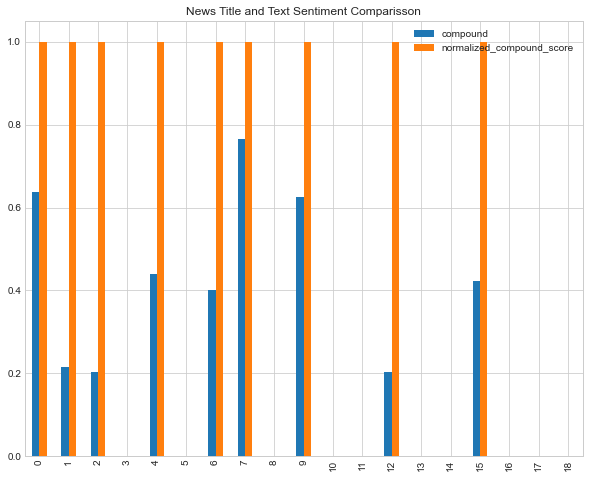

In [368]:
# Generate plots
bitcoin_df.plot(
    y=["compound", "normalized_compound_score"],
    kind="bar",
    title="News Title and Text Sentiment Comparisson",
    figsize=(10, 8),
    grid=True
)


<AxesSubplot:title={'center':'News Title and Text Sentiment Comparisson'}>

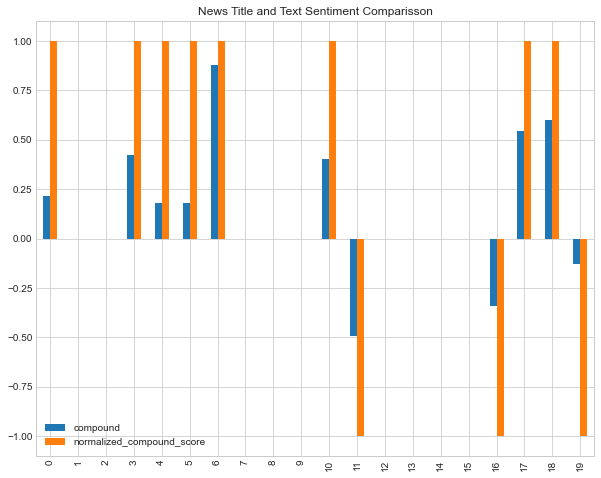

In [369]:
ethereum_df.plot(
    y=["compound", "normalized_compound_score"],
    kind="bar",
    title="News Title and Text Sentiment Comparisson",
    figsize=(10, 8),
    grid=True
)


<AxesSubplot:title={'center':'News Title and Text Sentiment Comparisson'}, xlabel='date'>

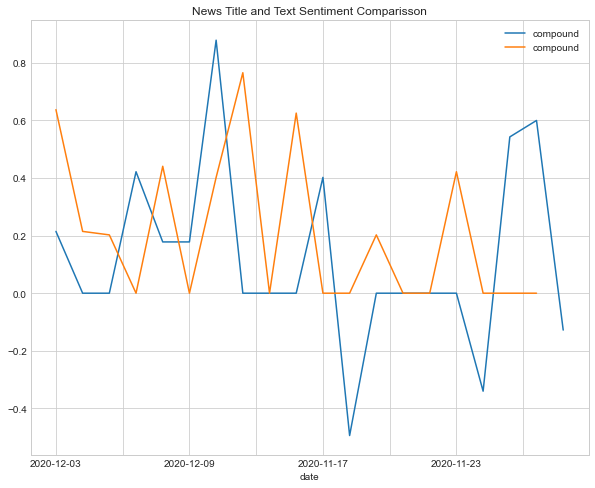

In [370]:
plt = ethereum_df.plot(
    x="date",
    y="compound",
    kind="line",
    title="News Title and Text Sentiment Comparisson",
    figsize=(20, 20),
    grid=True
)

bitcoin_df.plot(
    x="date",
    y="compound",
    kind="line",
    title="News Title and Text Sentiment Comparisson",
    figsize=(10, 8),
    grid=True,
    ax=plt
)


### Questions:

Q: Which coin had the highest mean positive score?

A: Ethereum has a higher mean positive score (0.060950) compared to that of Bitcoin (0.053526). This implies that articles have a generally more positive sentiment for ethereum than bitcoin.

Q: Which coin had the highest compound score?

A: Bitcoin has a higher compound score (0.205768) than ethereum (0.122565). Overall, Bitcoin has a higher level of confidence.

Q. Which coin had the highest positive score?

A: Ethereum has a higher maximum positive score (0.318000) than bitcoin (0.174000). This might imply that there is more excitement about ethereum.

---

# Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:

1. Lowercase each word
2. Remove Punctuation
3. Remove Stopwords

In [371]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [372]:
# Expand the default stopwords list if necessary
english_stopwords = set(stopwords.words('english'))
custom_stopwords = set(['said', 'sent', 'found', 'including', 'today', 'announced', 'week', 'basically', 'also', ',', 'weekly', 'bitcoin', 'ethereum', 'following', 'char', 'ha' ])

full_stopwords = english_stopwords.union(custom_stopwords)


In [373]:
"[" + punctuation + "]"

'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'

In [374]:
regex = re.compile("[" + punctuation + "]")
word = "="
print(re.match("[" + punctuation + "]+", word) is not None)

True


In [375]:
# Complete the tokenizer function
regex_punctuation_match_str = ".*[" + punctuation + "]+.*"
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    """Tokenizes text."""
    
    # Create a list of the words
    words = word_tokenize(text)

    # Convert the words to lowercase
    words = [word.lower() for word in words]

    # Remove the punctuation
    words = [word.lower() for word in words if re.match(regex_punctuation_match_str, word) is None]

    # regex = re.compile("[^a-zA-Z ]")
    # text = [regex.sub('', word) for word in text]

    # punctuation
    # regex = re.compile("[" + punctuation + "]")
    # re_clean = regex.sub('', article)
    

    # Lemmatize Words into root words
    words = [lemmatizer.lemmatize(word) for word in words]


    # Remove the stop words
    words = [word.lower() for word in words if word.lower() not in full_stopwords]

    return words


In [376]:
# an_array = []
# for text in bitcoin_df["text"].values:
#     an_array.append(tokenizer(text))

In [377]:
# Create a new tokens column for bitcoin
# bitcoin_df["tokens"] = []
# tokenizer(bitcoin_df["text"])

bitcoin_df_tokens = []
for text in bitcoin_df["text"].values:
    bitcoin_df_tokens.append(tokenizer(text))

bitcoin_df["tokens"] = bitcoin_df_tokens
bitcoin_df.head()


,date,text,compound,normalized_compound_score,positive,negative,neutral,tokens
0,2020-12-03,Visa has partnered with cryptocurrency startup...,0.6369,1,0.162,0.000,0.838,"[visa, partnered, cryptocurrency, startup, blo..."
1,2020-11-12,PayPal is bringing its newly-announced support...,0.2144,1,0.053,0.000,0.947,"[paypal, bringing, support, cryptocurrency, u,..."
2,2020-11-20,"In November 2017, after an absolutely massive,...",0.2023,1,0.050,0.000,0.950,"[november, 2017, absolutely, massive, rally, p..."
3,2020-12-06,"Unlike ‘conventional’ cryptocurrencies, a cent...",0.0000,0,0.000,0.000,1.000,"[unlike, ‘, conventional, ’, cryptocurrencies,..."
4,2020-11-25,If youve been watching the crypto markets over...,0.4404,1,0.152,0.075,0.773,"[youve, watching, crypto, market, past, youll,..."


In [378]:
# Create a new tokens column for ethereum
ethereum_df_tokens = []
for text in ethereum_df["text"].values:
    ethereum_df_tokens.append(tokenizer(text))

ethereum_df["tokens"] = ethereum_df_tokens
ethereum_df.head()


,date,text,compound,normalized_compound_score,positive,negative,neutral,tokens
0,2020-11-12,PayPal is bringing its newly-announced support...,0.2144,1,0.053,0.0,0.947,"[paypal, bringing, support, cryptocurrency, u,..."
1,2020-11-23,FILE PHOTO: Representation of the Ethereum vir...,0.0000,0,0.000,0.0,1.000,"[file, photo, representation, virtual, currenc..."
2,2020-11-23,FILE PHOTO: Representation of the Ethereum vir...,0.0000,0,0.000,0.0,1.000,"[file, photo, representation, virtual, currenc..."
3,2020-11-23,LONDON (Reuters) - Digital currencies Ethereum...,0.4215,1,0.088,0.0,0.912,"[london, reuters, digital, currency, xrp, soar..."
4,2020-12-07,NEW YORK (Reuters) - Institutional investors p...,0.1779,1,0.052,0.0,0.948,"[new, york, reuters, institutional, investor, ..."


---

# NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [379]:
from collections import Counter
from nltk import ngrams

In [380]:
# Generate the Bitcoin N-grams where N=2
bitcoin_ngrams = [ Counter(ngrams(token, n=2)) for token in bitcoin_df["tokens"].values ]
bitcoin_ngrams[0]


Counter({('visa', 'partnered'): 1,
         ('partnered', 'cryptocurrency'): 1,
         ('cryptocurrency', 'startup'): 1,
         ('startup', 'blockfi'): 1,
         ('blockfi', 'offer'): 1,
         ('offer', 'first'): 1,
         ('first', 'reward'): 1,
         ('reward', 'credit'): 1,
         ('credit', 'card'): 1,
         ('card', 'pay'): 1,
         ('pay', 'rather'): 1,
         ('rather', 'cash'): 1,
         ('cash', 'worth'): 1,
         ('worth', 'applying'): 1,
         ('applying', 'unless'): 1,
         ('unless', 'youre'): 1,
         ('youre', 'extremely'): 1,
         ('extremely', 'bullish'): 1,
         ('bullish', 'o…'): 1})

In [381]:
# Generate the Ethereum N-grams where N=2
ethereum_ngrams = [ Counter(ngrams(token, n=2)) for token in ethereum_df["tokens"].values ]
ethereum_ngrams[0]


Counter({('paypal', 'bringing'): 1,
         ('bringing', 'support'): 1,
         ('support', 'cryptocurrency'): 1,
         ('cryptocurrency', 'u'): 1,
         ('u', 'account'): 1,
         ('account', 'first'): 1,
         ('first', 'plan'): 1,
         ('plan', 'open'): 1,
         ('open', 'cryptocurrency'): 1,
         ('cryptocurrency', 'trading'): 1,
         ('trading', 'user'): 1,
         ('user', 'october'): 1,
         ('october', 'wa'): 1,
         ('wa', 'a…'): 1})

In [382]:
# Use the token_count function to generate the top 10 words from each coin
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)


In [383]:
# Get the top 10 words for Bitcoin
all_words_bitcoin = []
for token in bitcoin_df.tokens:
    all_words_bitcoin += token

token_count(all_words_bitcoin, 10)

# bitcoin_df["tokens"].values
# token_count(bitcoin_df["tokens"].values, 10)


[('currency', 8),
 ('photo', 8),
 ('file', 7),
 ('representation', 7),
 ('virtual', 7),
 ('reuters', 7),
 ('illustration', 6),
 ('cryptocurrency', 5),
 ('taken', 5),
 ('london', 5)]

In [384]:
all_words_bitcoin_str = ' '.join(all_words_bitcoin)
all_words_bitcoin_str

'visa partnered cryptocurrency startup blockfi offer first reward credit card pay rather cash worth applying unless youre extremely bullish o… paypal bringing support cryptocurrency u account first plan open cryptocurrency trading user october wa a… november 2017 absolutely massive rally passed first time next 20 day soared even higher reaching price roug… unlike ‘ conventional ’ cryptocurrencies central bank control digital yuan — case people ’ bank china move give country power theory stability freq… youve watching crypto market past youll noticed something special everyones favorite decentralized digital currency based hype lie general mal… six year launch crypotcurrency exchange financial service platform bitso company revealed closed 62 million financing capitalize crypto… decentralized exchange protocol allow crypto trader investor trade across different blockhains development significant new development come la… 4 market ended november large gain even small decline amp p 500 jum

In [385]:
# Get the top 10 words for Ethereum
all_words_ethereum = []
for token in ethereum_df.tokens:
    all_words_ethereum += token

token_count(all_words_ethereum, 10)


[('reuters', 14),
 ('photo', 10),
 ('representation', 9),
 ('virtual', 9),
 ('currency', 9),
 ('illustration', 8),
 ('file', 7),
 ('seen', 7),
 ('taken', 7),
 ('new', 6)]

# Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

In [386]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

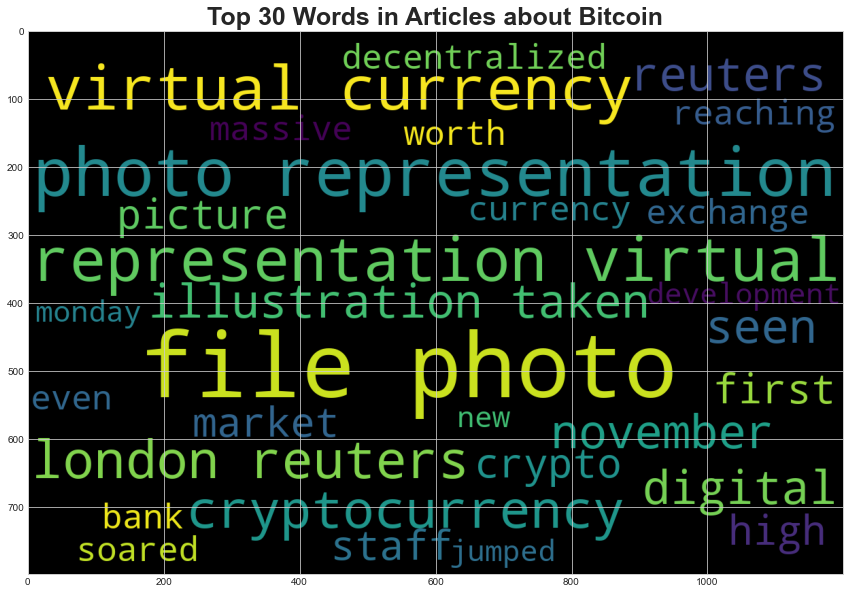

In [408]:
# Generate the Bitcoin word cloud
all_words_bitcoin_str = ' '.join(all_words_bitcoin)
num_bitcoin_words = 30
wc = WordCloud(width=1200, height=800, max_words=num_bitcoin_words).generate(all_words_bitcoin_str)
plt.title(f"Top {num_bitcoin_words} Words in Articles about Bitcoin", fontsize=25, fontweight="bold")
plt.imshow(wc)


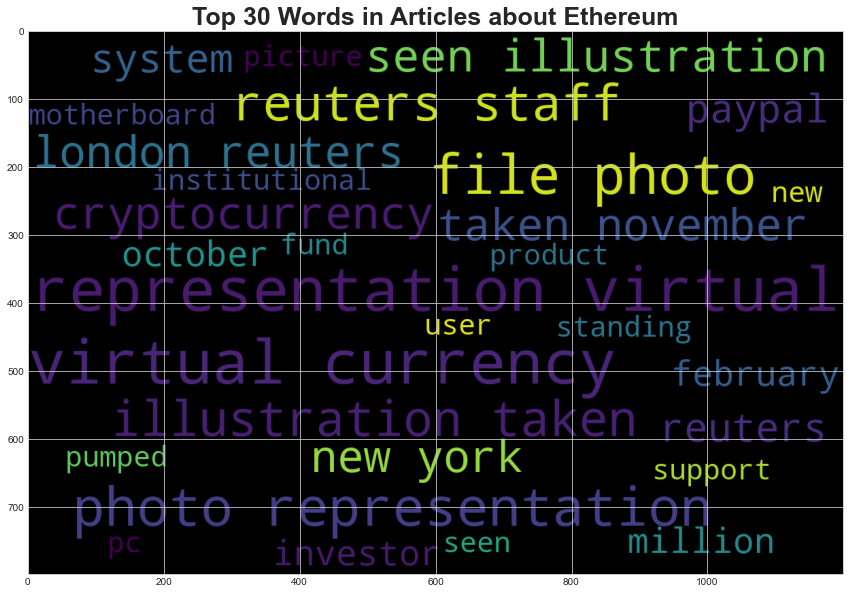

In [409]:
# Generate the Ethereum word cloud
all_words_ethereum_str = ' '.join(all_words_ethereum)
num_ethereum_words = 30
wc = WordCloud(width=1200, height=800, max_words=num_ethereum_words).generate(all_words_ethereum_str)
plt.title(f"Top {num_ethereum_words} Words in Articles about Ethereum", fontsize=25, fontweight="bold")
plt.imshow(wc)


# Named Entity Recognition

In this section, you will build a named entity recognition model for both coins and visualize the tags using SpaCy.

In [389]:
import spacy
from spacy import displacy

In [390]:
# Optional - download a language model for SpaCy
# !python -m spacy download en_core_web_sm

In [391]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

## Bitcoin NER

In [392]:
# Concatenate all of the bitcoin text together
# YOUR CODE HERE!

In [393]:
# Run the NER processor on all of the text
# YOUR CODE HERE!

# Add a title to the document
# YOUR CODE HERE!

In [394]:
# Render the visualization
# YOUR CODE HERE!

In [395]:
# List all Entities
# YOUR CODE HERE!

---

## Ethereum NER

In [396]:
# Concatenate all of the bitcoin text together
# YOUR CODE HERE!

In [397]:
# Run the NER processor on all of the text
# YOUR CODE HERE!

# Add a title to the document
# YOUR CODE HERE!

In [398]:
# Render the visualization
# YOUR CODE HERE!

In [399]:
# List all Entities
# YOUR CODE HERE!